In [81]:
%matplotlib notebook

import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import database
from snowballing.operations import reload, work_by_varname, load_work_map_all_years
from snowballing.strategies import Strategy, State
import custom_strategies
from functools import reduce
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt
import pandas as pd

custom_strategies.LIMIT_YEAR = 2015
reload()
# !pip install matplotlib-venn

In [82]:
from snowballing.operations import metakey, metakey_title

def busca(*libraries, seed=None, filter_function=None):
    filter_function = filter_function or (lambda x: x.category in ("snowball",))
    if seed is not None:
        iterable = ((1, work_by_varname(x)) for x in seed)
    else:
        iterable = load_work_map_all_years()
    seedset = set()
    visited = set()
    for _, work in iterable:
        for library in libraries:
            if int(getattr(work, library, 0)):
                visited.add(work)
                if filter_function(work):
                    seedset.add(work)
                break
    return seedset, filter_function, visited

def descreve_delta(strategy, state, name):
    target = state.find(name)
    previous_related = reduce(lambda x, y: x | y, (s.related for s in target.previous[0]), set())
    for work in previous_related:
        backward = set(strategy.ref[work]) & target.delta_visited
        if backward:
            print('backward', work.metakey)
            for ref in backward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')
        forward = set(strategy.rev_ref[work]) & target.delta_visited
        if forward:
            print('forward', work.metakey)
            for ref in forward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')

def separa_backward_forward(state):
    backward = set()
    forward = set()
    stack = [state]
    visited = {id(state)}
    while stack:
        current = stack.pop()
        if current.previous:
            if current.previous[1] == "backward":
                backward |= current.delta_related
            if current.previous[1] == "forward":
                forward |= current.delta_related
                
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.append(previous)
    return backward, forward

def encontraria(strategy, state):
    backward = set()
    forward = set()
    related = state.related - state.find("s0").related
    for work in state.related:
        backward |= (set(strategy.ref[work]) & related)
        forward |= (set(strategy.rev_ref[work]) & related)
    return backward, forward

#busca("scopus", seed=["wohlin2014a", "briand2000a"], filter_function=lambda x: True)
#busca("scopus", filter_function=lambda x: False)

# Estratégias

## Estratégia 1 - Busca em todas Digital Libraries (DL)

In [83]:
print ("Total de estudos primários usados como Seed Set: ", len ([x for _, x in load_work_map_all_years() if x.category == "snowball"]))


Total de estudos primários usados como Seed Set:  22


In [84]:
print ("Lista de estudos primários usados como Seed Set:")
([x for _, x in load_work_map_all_years() if x.category == "snowball"])

Lista de estudos primários usados como Seed Set:


[Exploring the use of the cynefin framework to inform software development approach decisions,
 An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI),
 Strategically balanced process adoption,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Defining and monitoring strategically aligned software improvement goals,
 Linking software development and business strategy through measurement,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 Utilizing GQM+ Strategies for an organization-wide earned value analysis,
 Utilizing GQM+ Strategies for business value analysis: An approach for evaluating business goals,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Entropy based software processe

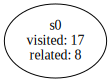

In [85]:
reload()
TOTAL = [x for _, x in load_work_map_all_years() if x.category == "snowball"]
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))

state = strategy.initial
strategy.initial.visited

#strategy.initial.name
state


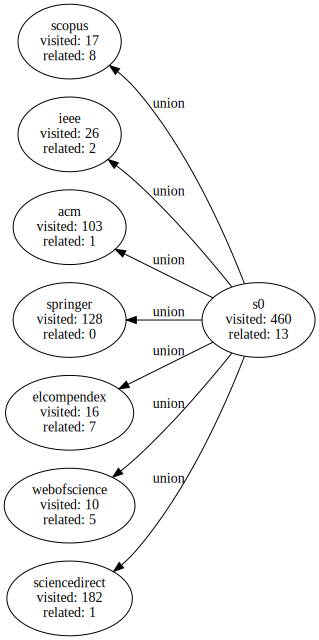

In [86]:
from snowballing.strategies import State

reload()
def busca_completa(libs, filter_function):
    union = None
    for dl in libs:
        strategy = Strategy(*busca(dl, filter_function=filter_function))
        strategy.initial.name = dl
        if union is None:
            union = strategy.initial.derive("union", name="s0")
        else:
            union.visited.update(strategy.initial.visited)
            union.related.update(strategy.initial.related)
            union.previous[0].append(strategy.initial)

    State.last_id = 0
    strategy.initial = union
    return strategy

strategy = busca_completa(["scopus", "ieee", "acm", "springer", "elcompendex", "webofscience", "sciencedirect"], filter_function)
#strategy.initial.find("acm")
strategy.initial

In [87]:
array = []

name = "E1"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E1
0.47058823529411764
Recall E1
0.36363636363636365


## Estratégia 2 - Busca em todas Digital Libraries + Snowballing (Guideline - sfbu)

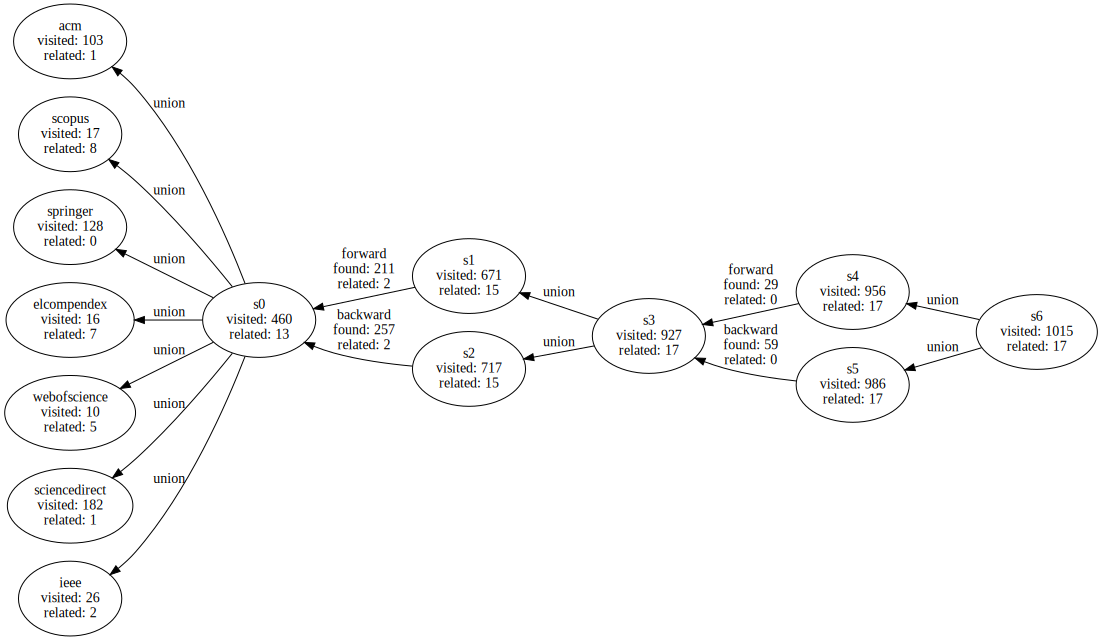

In [88]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = busca_completa(["acm", "scopus", "springer", "elcompendex", "webofscience", "sciencedirect", "ieee"], filter_function)
#Strategy(*busca("acm","scopus", filter_function=filter_function))

state = strategy.sfbu()
#state = strategy.bbff()
#state = strategy.ffbb()
#state = strategy.s2ffbb2u()

state

### Resumo 

#### Resumo da Busca em DL

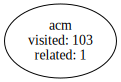

In [89]:
strategy.initial.find("acm")

In [90]:
# Visitados ACM
strategy.initial.find("acm").visited

{Towards a Conceptual Framework and Tool Support for Linking Long-term Product and Business Planning with Agile Software Development,
 Why Do Users Communicate via Such or Such Media?: Some Insights from Users' Daily Experiences,
 Alignment of Information Systems to Strategy in the Health Sector Using a Systems Dynamics Approach,
 Bridging Information Technology and Business&Mdash;Some Modelling Aspects,
 Dynamic and Stabilizing Forces in Knowledge Organization Systems for Business Ecosystems,
 eGov Website Evolution Study Within Strategic Planning,
 Optimal Positioning of Active and Passive Monitoring Devices,
 Reasoning About Partial Goal Satisfaction for Requirements and Design Engineering,
 Letter from the Editors,
 A Model to Incorporate Emotional Sensitivity into Human Computer Interactions,
 A Distributed Placement Service for Graph-structured and Tree-structured Data,
 HyperIntelligence: The Next Frontier,
 On-die Power Grids: The Missing Link,
 A Contingency View of Organizati

In [91]:
# Relacionados ACM - encontrado no seed set
strategy.initial.find("webofscience").related

{ProPAMet: a Metric for process and project alignment,
 An approach to support the strategic alignment of software process improvement programs,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations}

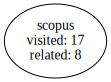

In [12]:
strategy.initial.find("scopus")

In [13]:
print("Visitados Scopus:")
strategy.initial.find("scopus").visited

Visitados Scopus:


{An approach to support the strategic alignment of software process improvement programs,
 Software process improvement for the airline industry,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 ProPAMet: a Metric for process and project alignment,
 A comparative study of SPI approaches with ProPAM,
 A Low-overhead method for software process appraisal,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Alignment between the business strategy and the software processes improvement: A roadmap for the implementation [Alinhamento entre estrategia de negocios e melhoria de processos de software: Um roteiro de implementacao],
 Using strategic planning for selection of SPI processes: An experience report,
 Linking software life cycle activities with product strategy and economics: Extending ISO/IEC 12207 with product management best practices,
 A case study applying process and project alignment methodology,
 Cr

In [14]:
print("Relacionados Scopus - encontrado no seed set:")
strategy.initial.find("scopus").related

Relacionados Scopus - encontrado no seed set:


{An approach to support the strategic alignment of software process improvement programs,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 ProPAMet: a Metric for process and project alignment,
 A Low-overhead method for software process appraisal,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations}

In [15]:
print("Artigo comum a ACM e Scopus:")
strategy.initial.find("acm").visited & strategy.initial.find("scopus").visited

Artigo comum a ACM e Scopus:


set()

#### Resumo do Snowballing

In [16]:
#Total de visitados = visitados no final - visitados no início
print ("Total visitados:")
len(state.visited - state.find("s0").visited)

Total visitados:


555

In [17]:
# Descrição dos Relacionados = relacionados no final - relacionados no início
print ("Total Relacionados: Lista dos que foram encontrados via Snowballing")
state.related - state.find("s0").related

Total Relacionados: Lista dos que foram encontrados via Snowballing


{Utilizing GQM+ Strategies for an organization-wide earned value analysis,
 Strategic alignment of software process improvement programs using QFD,
 An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI),
 Entropy based software processes improvement}

In [94]:
print ("Encontrados via somente Snowballing:")
diff_related = state.related - state.find("s2").related
diff_related @ metakey_title

Encontrados via somente Snowballing:


['mandić2010a - Utilizing GQM+ Strategies for an organization-wide earned value analysis',
 'petersen2015a - An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI)']

### Detalhamento por Estado / Aresta

#### Estado S0

#### Visitados

In [19]:
#S0 - Visitados
print("Visitados no Estado 0:")
state.find("s0").visited

Visitados no Estado 0:


{Calculating return on investment of training using process variation,
 Using FAME Assessments to Define Measurement Goals,
 Alignment of Information Systems to Strategy in the Health Sector Using a Systems Dynamics Approach,
 Bridging Information Technology and Business&Mdash;Some Modelling Aspects,
 Concern coverage in base station development: an empirical investigation,
 Fuzzy dynamics in software project simulation and support,
 Quantitative approach to software process improvement,
 No Improvement without Learning: Prerequisites for Learning the Relations between Process and Product Quality in Practice,
 Reasoning About Partial Goal Satisfaction for Requirements and Design Engineering,
 Best practice fusion of CMMI-DEV v1.2 (PP, PMC, SAM) and \PMBOK\ 2008,
 Special section,
 \ICT\ Infrastructure Created to Support CertiBPM Project and Training Program,
 A Low-overhead method for software process appraisal,
 Designing a Strategic Measurement Program for Software Engineering Organi

#### Relacionados - Seed Set

In [95]:
#S0 - Relacionados - Encontrados via busca e que existem na lista dos Incluídos da SLR existente - são os seed set!
print("Relacionados no Estado 0: Seed Set")
state.find("s0").related @ metakey_title

Relacionados no Estado 0: Seed Set


['trienekens2005a - Business-oriented process improvement: practices and experiences at Thales Naval The Netherlands (TNNL)',
 'becker2008a - An approach to support the strategic alignment of software process improvement programs',
 "reiblein1997a - SPI:\x91I can't get no satisfaction\x92-directing process improvement to meet business needs",
 'kaneko2011a - Application of GQM+ Strategies{\textregistered} in the Japanese space industry',
 'mandić2010b - Utilizing GQM+ Strategies for business value analysis: An approach for evaluating business goals',
 'sommerville1999a - Managing process inconsistency using viewpoints',
 'martins2008a - ProPAMet: a Metric for process and project alignment',
 'wilkie2007a - A Low-overhead method for software process appraisal',
 'basili2010a - Linking software development and business strategy through measurement',
 'albuquerque2009a - Software process improvement: Supporting the linking of the software and the business strategies',
 'plösch2011a - Soft

#### Aresta s0 -> s2 (Backward - Iteração 1)

In [21]:
# S2 - Backward (Found) - Visitados na iteração 1
print("Backward - Qtd Referencias dos artigos visitados para chegar ao Estado 2, a partir do Estado 0:")
state.find("s2").delta_visited

Backward - Qtd Referencias dos artigos visitados para chegar ao Estado 2, a partir do Estado 0:


{Handbook of qualitative research methods in entrepreneurship,
 Human, Social and Organizational Influences on the Software Process,
 Business value through product line engineering - a case study,
 Success factors of organizational change in software process improvement,
 Quality management systemsrequirements, international standards organization,
 Product Focused Software Process Improvement: Concepts and Experiences from Industry,
 Integrating Practical Software Measurement and the Balanced Scorecard,
 Artificial Intelligence: A Modern Approach,
 Process Improvement and the Corporate Balance Sheet,
 Information Technology - Software Process Assessment - Part 7: Guide for Use in Process Improvement,
 Aligning strategic and project measurement systems,
 The Balanced Scorecard: Measures that Drive Performance,
 Viewpoints for Requirements Definition,
 The book,
 Requirements Engineering with Viewpoints,
 Guest editors' introduction: Return on investment,
 Information Technology - Ame

In [22]:
# S2 - Backward (Related) - Encontrados na iteração 1, via snowballing, que não foi encontrado via busca para o seed set.
print("Relacionados encontrados via Backward, para chegar ao Estado 2, a partir do Estado 0:")
state.find("s2").delta_related @ metakey_title

Relacionados encontrados via Backward, para chegar ao Estado 2, a partir do Estado 0:


['becker2008b - Strategic alignment of software process improvement programs using QFD',
 'trienekens2009a - Entropy based software processes improvement']

#### Aresta s0 -> s1 (Forward - Iteração 1)

In [23]:
# S1 - Forward (Related) - Encontrados na iteração 1
print("Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:")
state.find("s1").delta_related @ metakey_title

Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:


['mandić2010a - Utilizing GQM+ Strategies for an organization-wide earned value analysis',
 'petersen2015a - An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI)']

#### Relacionados - Encontrados Via Backward e Forward

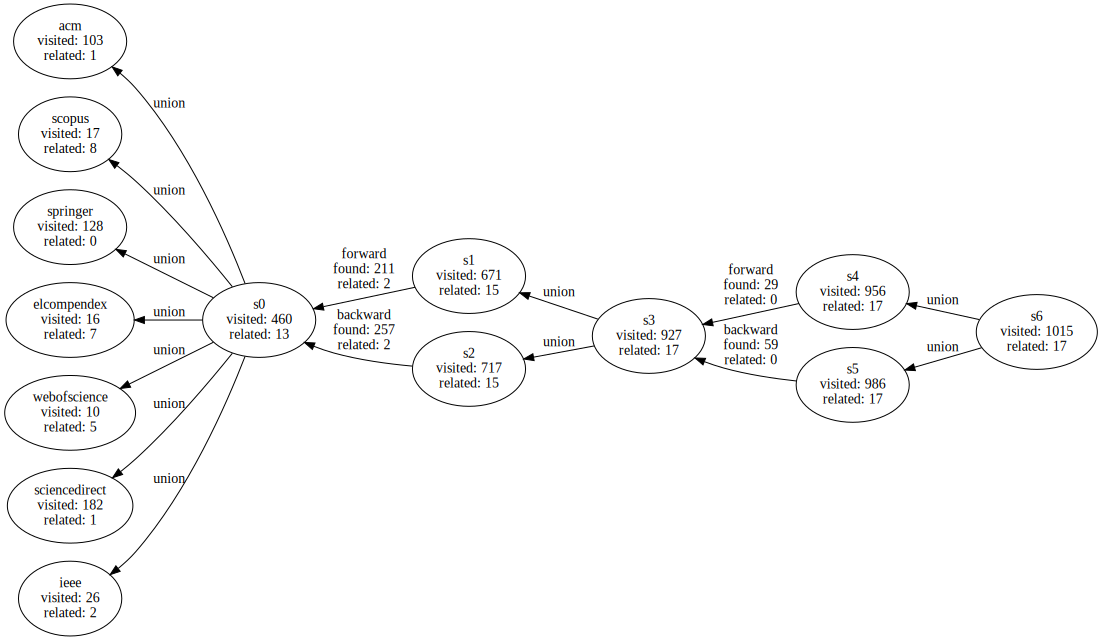

In [24]:
state

In [25]:
# Quantidade de artigo que existe em mais de uma biblioteca, após a união, no Estado S0, Ex, existe 1 artigo em acm e scopus.
state.find("s0").previous[0][1]

(len(strategy.initial.find("acm").visited) + len(strategy.initial.find("scopus").visited) + len(strategy.initial.find("elcompendex").visited) + len(strategy.initial.find("springer").visited) + len(strategy.initial.find("webofscience").visited) + len(strategy.initial.find("sciencedirect").visited)) - len(state.find("s0").visited)

-4

In [26]:
# Artigos encontrados via Backward e Forward - Foi incluído kitchenham 2007a como Snowball para o teste.
print ("Encontrados via Backward e Forward:")
separa_backward_forward(state) @ metakey_title

Encontrados via Backward e Forward:


[['becker2008b - Strategic alignment of software process improvement programs using QFD',
  'trienekens2009a - Entropy based software processes improvement'],
 ['mandić2010a - Utilizing GQM+ Strategies for an organization-wide earned value analysis',
  'petersen2015a - An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI)']]

In [27]:
def duplicados(strategy, state):
    encontrados = set()
    result = set()
    soma = 0
    related = state.related - state.find("s0").related
    for work in state.related:
        inter = encontrados & (set(strategy.ref[work]) & related)
        if inter:
            soma += len(inter)
            encontrados |= inter
            print(work @ metakey, "backward", inter @ metakey)
        inter = encontrados & (set(strategy.rev_ref[work]) & related)
        if inter:
            soma += len(inter)
            encontrados |= inter
            print(work @ metakey, "forward", inter @ metakey)
    return soma

In [28]:
strategy.forward??

In [29]:
duplicados(strategy, state)

0

<IPython.core.display.Javascript object>


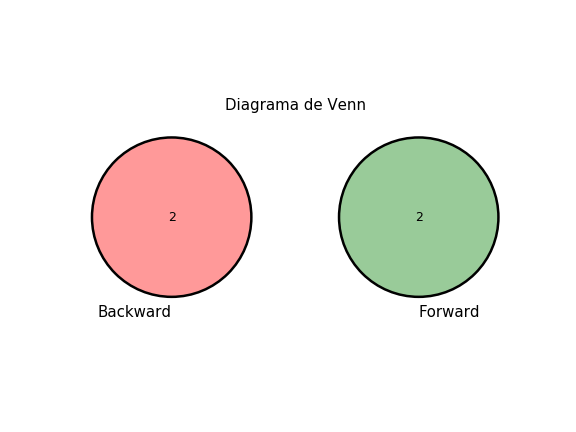

In [30]:
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title('Diagrama de Venn')
plt.show()

In [31]:
#Backward - Execução de backward em sets[0]
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)

Backward ['becker2008b', 'trienekens2009a']
Forward ['mandić2010a', 'petersen2015a']


In [32]:
state.find("s0").related @ metakey

['trienekens2005a',
 'becker2008a',
 'reiblein1997a',
 'kaneko2011a',
 'mandić2010b',
 'sommerville1999a',
 'martins2008a',
 'wilkie2007a',
 'basili2010a',
 'albuquerque2009a',
 'plösch2011a',
 'guzmán2010a',
 'barreto2010a']

In [ ]:
#x = v.get_patch_by_id('100')

In [ ]:
#x.set_linestyle = "black"

In [ ]:
#[x.metakey for x in state.find("s0").related]

#### Execução de Backward (Aresta S0 -> S2) em cada artigo relacionado do S0

In [33]:
print("Descreve o S0 -> S2:\n Execução de Backward em cada artigo do related \n")
descreve_delta(strategy, state, "s2")

Descreve o S0 -> S2:
 Execução de Backward em cada artigo do related 

backward trienekens2005a
- gack2003a 
- stelzer1998a 
- trienekens2001a 
- cattaneo2001a 
- debou2000a 
- mellis1998a 
- solingen1999a 
- neiger2003a 
- latum1998a 
- kaplan2001a 
- iso2005a 
- paulk1995b 
- dawson2003a 
- balla2001a 
- solingen2000b 
backward becker2008a
- pulford1996a 
- brodman1995a 
- humphrey1989b 
- zahran1998a 
- akao1990a 
- grady1997a 
- zaijun2005a 
- dyba2005a 
- yin2003a 
- peterson1995a 
- mccoy1998a 
- pitterman2000a 
- hierholzer1998a 
- weber2005a 
- montoni2007a 
- paulk1993a 
- biró1999a 
- isoiec2003a 
- debou1999a 
- niazi2003a 
- chrissis2003a 
- cox1992a 
- yamamura1999a 
- liu2005a 
backward reiblein1997a
- miller1995a 
- group1997a 
- vlasveld1995a 
- kaplan1993a 
- itil1989a 
- iso1994b 
- kaplan1996b 
- trade1992a 
- humphrey1989a 
- hinley1997a 
- isoies1997a 
- cmm1993a 
- deming1986a 
- iso1994a 
backward kaneko2011a
- jaxa2012a 
- kaplan1992a 
- isaca2005a 
- isaca2008a

#### Execução de Forward em cada artigo relacionado do S1

In [34]:
print("Descreve o S0 -> S1:\n Execução de Forward em cada artigo do related \n")
descreve_delta(strategy, state, "s1")

Descreve o S0 -> S1:
 Execução de Forward em cada artigo do related 

forward trienekens2005a
- lohrmann2013a 
- shahzad2012a 
- vuk2010a 
- chen2008a 
- songnisai2008a 
- savioja2007a 
- chen2007a 
- brenda2013a 
- glykas2014a 
- siritanachot2008a 
- glykas2011a 
forward reiblein1997a
- stelzer1998b 
- schalken2007a 
- donkin2002a 
- baddoo2001a 
- alshawi2007a 
- bowers2001a 
- makipaa2004a 
- murakami2007a 
- brouwer2007a 
- halloran1999a 
forward kaneko2011a
- heidrich2012b 
- trinkenreich2015a 
- kobori2014a 
- petersen2015a related
- teixeira2013a 
- razón2014b 
- razón2014a 
- asghari2012a 
backward mandić2010b
- mandić2010c 
forward mandić2010b
- tyrväinen2015a 
- dymek2015a 
- kobori2014a 
- kobori2014b 
- petersen2015a related
- cocozza2014a 
- basili2014b 
- fernández2011a 
- astromskis2014a 
- trendowicz2014a 
- mandić2010g 
- ellis2012a 
- roditi2014a 
- münch2013c 
- ellis2013a 
- asghari2012a 
- hyvönen2015a 
- papa2015a 
- mandić2010a related
- basili2014c 
forward somm

#### Resumo do Precision e Recall

In [35]:
E2P = len (strategy.initial.related) / len (strategy.initial.visited)
#print (len (strategy.initial.related))
#print (len (strategy.initial.visited))
#print (E2P)
print ("Precision na Busca E2: %.2f%%" % E2P)

#print ("Precision no Snowballing - E2:")
#print(len(state.related - state.find("s0").related))
#print(len(state.visited - state.find("s0").visited))

E2PS = len(state.related - state.find("s0").related) / len(state.visited - state.find("s0").visited)

print ("\n""Precision no Snowballing E2: %.2f%%" % E2PS)

print("Precision no Snowballing E2 - Forward - 1 iteração: %.2f%%" % (len (state.find("s1").delta_related) / len (state.find("s1").delta_visited)))

print("Precision no Snowballing E2 - Backward - 1 iteração: %.2f%%" % (len (state.find("s2").delta_related) / len (state.find("s2").delta_visited)))

print("\n""Precision E2 (Busca + Snowballing): %.2f%%" % (len(state.related) / len(state.visited)))

#len (state.find("s1").related)

#len (state.find("s1").delta_related)
#len (state.find("s1").delta_visited)


name = "E2"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision na Busca E2: 0.03%

Precision no Snowballing E2: 0.01%
Precision no Snowballing E2 - Forward - 1 iteração: 0.01%
Precision no Snowballing E2 - Backward - 1 iteração: 0.01%

Precision E2 (Busca + Snowballing): 0.02%
Precision E2
0.016748768472906402
Recall E2
0.7727272727272727


In [36]:
from collections import deque
def precision_recall(state, total, stop=""):
    # Precisao 0 quando nao visita nada
    array = [[
        "state", "precision", "recall", "operation", 
        "related", "visited", "delta_related", "delta_visited",
        "accumulated_precision", "accumulated_recall",
    ]]
    stack = deque([state])
    visited = {id(state)}
    while stack:
        current = stack.pop()
        try:
            accumulated_precision = len(current.related) / len(current.visited)
            precision = len(current.delta_related) / len(current.delta_visited)
        except ZeroDivisionError:
            precision = 0.0
            
        array.append([
            current.name,
            precision,
            len(current.delta_related) / len(total),
            current.previous[1] if current.previous else "-",
            len(current.related),
            len(current.visited),
            len(current.delta_related),
            len(current.delta_visited),
            accumulated_precision,
            len(current.related) / len(total),
        ])
        if current.name == stop:
            break
        if current.previous:              
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.appendleft(previous)
    return array

In [37]:
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
df

14,state,precision,recall,operation,related,visited,delta_related,delta_visited,accumulated_precision,accumulated_recall
0,ieee,0.0769231,0.0909091,-,2,26,2,26,0.0769231,0.0909091
1,sciencedirect,0.00549451,0.0454545,-,1,182,1,182,0.00549451,0.0454545
2,webofscience,0.5,0.227273,-,5,10,5,10,0.5,0.227273
3,elcompendex,0.4375,0.318182,-,7,16,7,16,0.4375,0.318182
4,springer,0,0,-,0,128,0,128,0,0
5,scopus,0.470588,0.363636,-,8,17,8,17,0.470588,0.363636
6,acm,0.00970874,0.0454545,-,1,103,1,103,0.00970874,0.0454545
7,s0,0,0,union,13,460,0,0,0.0282609,0.590909
8,s2,0.0077821,0.0909091,backward,15,717,2,257,0.0209205,0.681818
9,s1,0.00947867,0.0909091,forward,15,671,2,211,0.0223547,0.681818


<IPython.core.display.Javascript object>


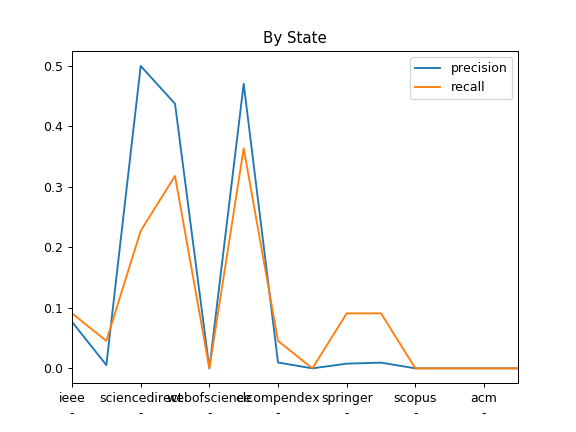

In [38]:
fig = plt.figure()
df['precision'].plot(legend=True)
df['recall'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("By State");

<IPython.core.display.Javascript object>


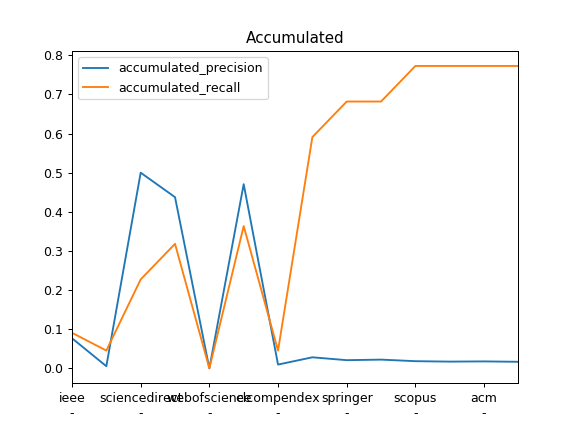

In [39]:
fig = plt.figure()
df['accumulated_precision'].plot(legend=True)
df['accumulated_recall'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("Accumulated");

## Estratégia 3 - Busca Informal (Google Scholar) + Snowballing (Guideline - sfbu)

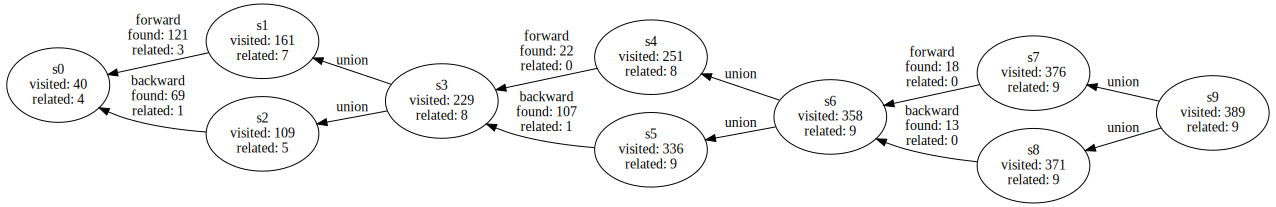

In [40]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("gs", filter_function=filter_function))
state = strategy.sfbu()
state

In [41]:
name = "E3"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E3
0.02313624678663239
Recall E3
0.4090909090909091



## Estratégia 4 - Busca em Scopus + Snowballing (Guideline - sfbu)

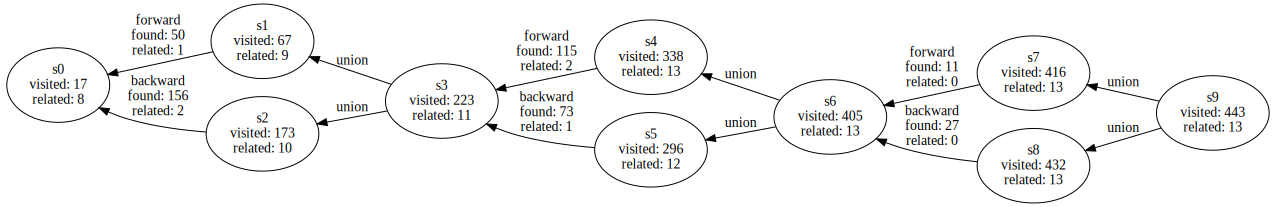

In [42]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))

#from copy import copy
#strategy.initial.visited = copy(strategy.initial.related)
state = strategy.sfbu()
state

In [43]:
descreve_delta(strategy, state, "s2")


backward becker2008a
- pulford1996a 
- brodman1995a 
- humphrey1989b 
- zahran1998a 
- akao1990a 
- grady1997a 
- zaijun2005a 
- dyba2005a 
- yin2003a 
- peterson1995a 
- mccoy1998a 
- pitterman2000a 
- hierholzer1998a 
- weber2005a 
- montoni2007a 
- paulk1993a 
- biró1999a 
- isoiec2003a 
- debou1999a 
- niazi2003a 
- chrissis2003a 
- cox1992a 
- yamamura1999a 
- liu2005a 
backward reiblein1997a
- miller1995a 
- group1997a 
- vlasveld1995a 
- kaplan1993a 
- itil1989a 
- iso1994b 
- kaplan1996b 
- trade1992a 
- humphrey1989a 
- hinley1997a 
- isoies1997a 
- cmm1993a 
- deming1986a 
- iso1994a 
backward kaneko2011a
- jaxa2012a 
- kaplan1992a 
- isaca2005a 
- isaca2008a 
- basili1992a 
- ogc2002a 
- becker1999a 
- basili2007b 
- basili2009a 
- kowalczyk2010a 
- kathuria2007a 
backward martins2008a
- isoiec1998a 
- krasner1997a 
- pfleeger1994a 
- cmm2002a 
- arthur1993a 
- emam1999a 
- kuvaja1994a 
- solingen1999a 
- paulk1993a 
- salo2005a 
- isoiec1998c 
- vertage1994a 
- isoiec1998b 

In [44]:
texto = """backward becker2008a
- weber2005a 
- hierholzer1998a 
- debou1999a 
- liu2005a 
- yamamura1999a 
- cox1992a 
- grady1997a 
- biró1999a 
- mccoy1998a 
- dyba2005a 
- humphrey1989b 
- paulk1993a 
- chrissis2003a 
- zaijun2005a 
- peterson1995a 
- brodman1995a 
- akao1990a 
- pitterman2000a 
- pulford1996a 
- montoni2007a 
- yin2003a 
- isoiec2003a 
- zahran1998a 
- niazi2003a 
backward martins2008a
- arthur1993a 
- isoiec1998a 
- salo2005a 
- krasner1997a 
- kuvaja1994a 
- cmm2002a 
- isoiec1998c 
- isoiec1998b 
- emam1999a 
- pfleeger1994a 
- solingen1999a 
- paulk1993a 
- vertage1994a 
- martins2007b 
backward reiblein1997a
- kaplan1993a 
- miller1995a 
- trade1992a 
- hinley1997a 
- vlasveld1995a 
- deming1986a 
- group1997a 
- iso1994b 
- itil1989a 
- iso1994a 
- cmm1993a 
- humphrey1989a 
- isoies1997a 
- kaplan1996b 
backward albuquerque2009a
- birk2002a 
- stalhane2004a 
- prahalad1999a 
- softex2009a 
- boehm2000b 
- cmusei2006a 
- nollen2008a 
- salo2005b 
- wright2000a 
- isoiec2004a 
- lawrence2001a 
- reed2000a 
- cater2004a 
- dybå2003b 
- birk1998a 
- bardin1977a 
- hefner2001a 
- thompson2000a 
- kim1995a 
- isoiec2004b 
- alloui2000a 
- caivano2005a 
- mcnair1990a 
- kaplan2000a 
- adams1993a 
- komi2004a 
- martins2007b 
backward kaneko2011a
- kathuria2007a 
- isaca2005a 
- kaplan1992a 
- basili2009a 
- basili2007b 
- becker1999a 
- isaca2008a 
- ogc2002a 
- basili1992a 
- jaxa2012a 
- kowalczyk2010a 
backward guzmán2010a
- ebert2007a 
- mcgarry2002a 
- goethert2004a 
- kaplan2008a 
- chastek2009a 
- tuan2006a 
- basili2009b 
- el2007a 
- sei2006b 
- kojima2008a 
- mishra2008a 
- long2008a 
- watson2007a 
- kanji2007a 
- oliveira2009a 
- porter1979a 
- lamb1984a 
- isoiec2007a 
- asgarkhani2006a 
- harjumaa2008a 
- mcloone2007a 
- mehra2004a 
- kamel2009a 
- card2003a 
- neergaard2007a 
- basili2010a related
- kaplan2005a 
- gopal2005a 
- peng2007a 
- kahraman2007a 
- isoiec2004a 
- fahey2007a 
- kaplan2006a 
- trienekens2009a related
- dyba2005a 
- shull2006a 
- el2001a 
- qi2007a 
- issac2006a 
- isoiec2008a 
- kaplan1997a 
- kuppusamy2008a 
- capell2004a 
- goethert2003a 
backward wilkie2007a
- iso2006a 
- anacleto2004b 
- wilkie2005a 
- mcfeeley1996a 
- anacleto2004a 
- makinen2000a 
- caffery2004a 
- sei2004a 
- wilkie2004a 
- cspt2003a 
- institute2005a 
- chrissis2003a 
- ISOIEC2006a 
- caffery2005a 
- mcfall2003a 
- sei2005a 
- paulk1995a 
- cignoni1999a 
- team2007a 
- rout2001a 
backward plösch2011a
- shewhart1931a 
- isoiec2003b 
- simon2002a 
- venzin2003a 
- cmmi2006a 
- mcfeeley1996a 
- isoiec1998d 
- dion1993a"""

In [45]:
conjuntos = [set(x.split("-")[1:]) for x in texto.split("backward")[1:]]

In [46]:
conjuntos[0] & conjuntos[1]

{' paulk1993a \n'}

In [47]:
name = "E4"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E4
0.029345372460496615
Recall E4
0.5909090909090909


In [48]:
state.find("s0").related

{An approach to support the strategic alignment of software process improvement programs,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 ProPAMet: a Metric for process and project alignment,
 A Low-overhead method for software process appraisal,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations}

In [49]:
state.find("s2").related

{An approach to support the strategic alignment of software process improvement programs,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 ProPAMet: a Metric for process and project alignment,
 A Low-overhead method for software process appraisal,
 Entropy based software processes improvement,
 Linking software development and business strategy through measurement,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations}

In [50]:
state.find("s0").visited

{An approach to support the strategic alignment of software process improvement programs,
 Software process improvement for the airline industry,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 ProPAMet: a Metric for process and project alignment,
 A comparative study of SPI approaches with ProPAM,
 A Low-overhead method for software process appraisal,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Alignment between the business strategy and the software processes improvement: A roadmap for the implementation [Alinhamento entre estrategia de negocios e melhoria de processos de software: Um roteiro de implementacao],
 Using strategic planning for selection of SPI processes: An experience report,
 Linking software life cycle activities with product strategy and economics: Extending ISO/IEC 12207 with product management best practices,
 A case study applying process and project alignment methodology,
 Cr

In [51]:
# Com backward de mendes2004a é possível encontrar 2 (resultado da celula)
state.related & set(strategy.ref[work_by_varname("mendes2004a")])

set()

In [52]:
# Com backward de ... em S2, encontrou 1 (resultado da celula)
state.find("s2").delta_related & set(strategy.ref[work_by_varname("mendes2004a")])

set()

In [53]:
# Com forward de ... em S1, encontrou 1 (resultado da celula)
state.find("s1").delta_related & set(strategy.rev_ref[work_by_varname("mendes2004a")])

set()

In [54]:
len(state.find("s1").delta_visited)

50

In [55]:
#len(state.find("s1").delta_visited & set(strategy.rev_ref[work_by_varname("mendes2004a")]))
# forward
len(set(strategy.rev_ref[work_by_varname("mendes2004a")]))

0

In [56]:
# backward
len(set(strategy.ref[work_by_varname("mendes2004a")]))

0

In [57]:
search_state = strategy.initial
search_state.related

{An approach to support the strategic alignment of software process improvement programs,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 ProPAMet: a Metric for process and project alignment,
 A Low-overhead method for software process appraisal,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations}

## Estratégia 5 - Busca em Scopus + Snowballing (Short Paper - s2ffbb2u)

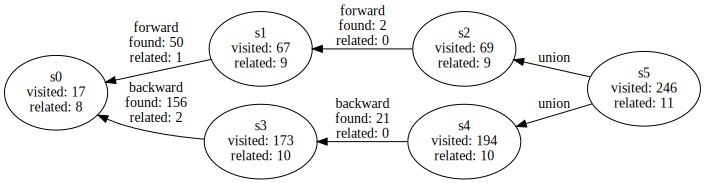

In [68]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.s2bbff2u()
state

In [69]:
name = "E5"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E5
0.044715447154471545
Recall E5
0.5


In [70]:
state.find("s0").related 

{An approach to support the strategic alignment of software process improvement programs,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 ProPAMet: a Metric for process and project alignment,
 A Low-overhead method for software process appraisal,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations}

In [71]:
state.find("s1").related 

{An approach to support the strategic alignment of software process improvement programs,
 An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI),
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 ProPAMet: a Metric for process and project alignment,
 A Low-overhead method for software process appraisal,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations}

In [72]:
state.find("s3").related 

{An approach to support the strategic alignment of software process improvement programs,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 ProPAMet: a Metric for process and project alignment,
 A Low-overhead method for software process appraisal,
 Entropy based software processes improvement,
 Linking software development and business strategy through measurement,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations}

In [73]:
sx, sy = state.previous[0]

sx.related & sy.related


{ProPAMet: a Metric for process and project alignment,
 A Low-overhead method for software process appraisal,
 An approach to support the strategic alignment of software process improvement programs,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations}

In [74]:
sx.name

's2'

In [75]:
sy.name

's4'

In [76]:
# Artigos encontrados via Backward e Forward - Foi incluído kitchenham 2007a como Snowball para o teste.
print ("Encontrados via Backward e Forward:")
separa_backward_forward(state) @ metakey_title

Encontrados via Backward e Forward:


[['basili2010a - Linking software development and business strategy through measurement',
  'trienekens2009a - Entropy based software processes improvement'],
 ['petersen2015a - An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI)']]

In [79]:
# S1 - Forward (Related) - Encontrados na iteração 1
print("Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:")
state.find("s1").delta_related @ metakey_title

Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:


['petersen2015a - An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI)']

## Estratégia 6 - Busca em Scopus + Snowballing (JF - bbff)

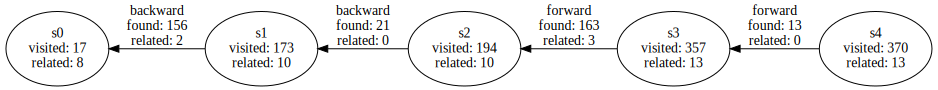

In [66]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.bbff()
state

In [67]:
strategy._repeat??

In [ ]:
name = "E6"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

## Estratégia 7 - Busca em Scopus + Snowballing (JF - ffbb)

In [ ]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.ffbb()
state

In [ ]:
name = "E7"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

# Análise das Estratégias

In [ ]:
%matplotlib notebook
import pandas as pd

In [ ]:
df = pd.DataFrame (array,columns = ['Estratégia','Precision','Recall'])
df.index = df['Estratégia']
df

In [ ]:
import matplotlib.pyplot as plt
ax = df.plot.bar(title ="Precision e Recall das Estratégias")
plt.tight_layout()


In [ ]:
df

In [ ]:
#df.to_csv("estrategias.csv")
df.to_excel("estrategias.xlsx")

# Individual

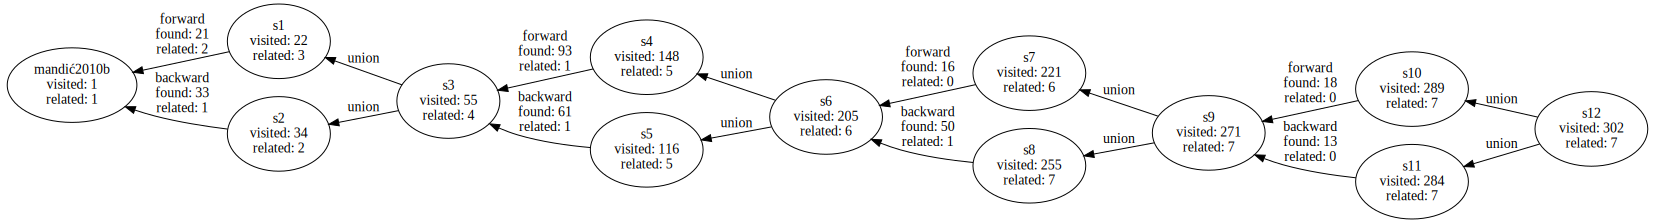

In [100]:
reload()
#NAME = "guzmán2010a"
NAME = "mandić2010b"
filter_function = lambda x: x.category in ("snowball", "forward", "backward")
seedset = {work_by_varname(NAME)}
strategy = Strategy(seedset, filter_function)
strategy.initial.name = NAME
state = strategy.sfbu()
state

In [101]:
state.find("s2").delta_visited

{Business value through product line engineering - a case study,
 Measurement and decision making,
 Value-based software engineering: Overview and agenda,
 Guest editors' introduction: Return on investment,
 Managing a designer/2000 project,
 Value creation and capture: A model of the software development process,
 An economic approach for improving requirements negotiation models with inspection,
 Linking software development and business strategy through measurement,
 Calculating ROI for software product lines,
 The experience factory and its relationship to other improvement paradigms,
 Bridging the gap between business strategy and software development,
 Early empirical assessment of the practical value of GQM +strategies,
 Uncertainty and Risk Analysis : A Practical Guide from Business Dynamics.,
 Value-based software engineering: A case study,
 Value-based software engineering: Overview and agenda,
 Measuring the ROI of software process improvement,
 Risk and the economic value o

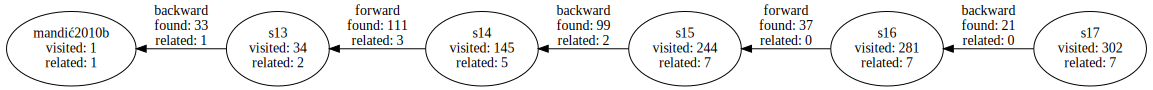

In [103]:
strategy.bfbf()